# Introduction


## Data Challenge for the course Machine Learning and Data Mining

### Authors: 
#### Pavlo Mozharovskyi (pavlo.mozharovskyi@telecom-paris.fr), Awais Hussain Sani, Stephan Clémençon


# Supervised anomaly detection

**Anomaly detection** (or **outlier detection**) comprises the **machine learning** methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. 

This data set is provided by Valeo, the French one of the largest Original Equipment Manufacturer. It regards the task of the supervised anomaly detection on a production line. For each of the produced items, a set of properties are measured, and finally a special testing procedure verifies that the item is intact. Thus, all the observations are labeled as normal or defect (anomalies), with anomalies being rare.

Statistically, this is formalized as the supervised anomaly detection, because the correct labels are given during training. This can also be seen as a task of supervised classification with two very dis-equilibrated classes.

You are suggested to construct an anomaly detection rule which, for each new observation, provides an anomaly score, that is the score is higher for more abnormal observation. This would allow to detect anomaly just based on measured parameters of the item without running a mechanical testing procedure.

# The properties of the dataset:


The data set is provided by Valeo and consistst of the measures of 27 properties of produced items and their labels identifying whether an item is intact or defect (= anomaly).

### Training data: 

The training set consists of files, **valeo_xtrain.csv** and **valeo_ytrain.csv**.

File **valeo_xtrain.csv** contains one observation per row, each observation having 27 entries.

File **valeo_ytrain.csv** contains one observation per row, each observation having 1 entry identifying whether it is an anomay (**1**) or not (**0**).

There are in total **27586** training observations.

### Test data:

The testing set consists of one file, **valeo_xtest.csv**, which has the same structure as file **valeo_xtrain.csv**.

There are in total **27587** test observations.

### Remark:

The task of the **supervised anomaly detection** can be difficult, in the sense that the classes are heavily disequilibrated.

## The performance criterion:

You should submit a file that contains in each row anomaly score (a real vaule) for the observation in the corresponding row of the file **valeo_xtest.csv**. For a sample submission please see the code below. Please note, that your score should provide ordering which allows to identify anomalies, i.e., the higher the value of the score, the **more abnormal** the observation should be considered.

The performance criterion is the **Area Under the Receiver Operating Characteristic** (AUC), see also:
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve

# Training Data

Training data, input (file **valeo_xtrain.csv**): https://partage.imt.fr/index.php/s/W3WDoTmB6jJrPZp

Training data, input (file **valeo_ytrain.csv**): https://partage.imt.fr/index.php/s/YAXDEXx6XJtf3X8

# Test Data 

Training data, output (file **valeo_xtest.csv**): https://partage.imt.fr/index.php/s/TCoKd6DMegpmmqL

# Imports

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import roc_curve, roc_auc_score, plot_precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier

---
# Analyse exploratoire

In [2]:
xtrain = pd.read_csv("data/valeo_xtrain.csv") # train and validation
ytrain = pd.read_csv("data/valeo_ytrain.csv") # train and validation
xtest = pd.read_csv("data/valeo_xtest.csv") # test

---
## xtrain

In [3]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27586 entries, 0 to 27585
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   START2_OP020_V_1angle                      27586 non-null  float64
 1   START2_OP020_V_1torque                     27586 non-null  float64
 2   START2_OP020_V_2angle                      27586 non-null  float64
 3   START2_OP020_V_2torque                     27586 non-null  float64
 4   START2_OP040_Vision_cosseprog              27586 non-null  float64
 5   START2_OP050_Vision_paliermodel            27586 non-null  float64
 6   START2_OP050_Vision_palierpresencedouille  27586 non-null  float64
 7   START2_OP060_Vision_tirantcouleur          27586 non-null  float64
 8   START2_OP070_V_1angle                      27586 non-null  float64
 9   START2_OP070_V_1prog                       27586 non-null  float64
 10  START2_OP070_V_1torque

In [4]:
xtrain.describe()

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,...,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
count,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,...,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000,27586.000000
mean,37.986635,3.775921,40.137958,3.777499,740.714420,1.670558,1.001486,1.329442,131.754241,7.330929,...,11.754024,84.061620,164.210221,30.445088,0.404118,22.743551,1.267020,11.492708,124.649516,11.958262
std,7.680003,0.017038,6.488604,0.012722,442.872201,0.470019,0.038524,0.470019,22.006941,0.470556,...,0.253366,15.176692,29.851088,11.815632,0.142146,12.199751,0.442411,1.165320,10.697002,0.264335
min,19.000000,3.750000,21.300000,3.750000,3.000000,1.000000,1.000000,1.000000,81.900000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,1.000000,0.060000,101.980000,3.050000
25%,31.700000,3.760000,35.000000,3.770000,300.000000,1.000000,1.000000,1.000000,110.200000,7.000000,...,11.590000,71.820000,136.630000,22.620000,0.230000,13.900000,1.000000,9.660000,116.560000,11.970000
50%,36.500000,3.770000,39.600000,3.770000,700.000000,2.000000,1.000000,1.000000,137.800000,7.000000,...,11.750000,82.135000,171.915000,27.020000,0.410000,17.700000,1.000000,12.160000,121.740000,11.970000
75%,43.600000,3.790000,45.000000,3.790000,1300.000000,2.000000,1.000000,2.000000,148.400000,8.000000,...,11.850000,92.900000,189.370000,36.990000,0.540000,30.800000,2.000000,12.220000,132.790000,11.970000
max,68.300000,3.850000,67.300000,3.830000,1500.000000,2.000000,2.000000,2.000000,208.300000,8.000000,...,12.580000,138.260000,237.170000,93.800000,0.600000,132.700000,2.000000,12.470000,206.370000,12.010000


In [5]:
xtrain.nunique()

START2_OP020_V_1angle                         393
START2_OP020_V_1torque                         11
START2_OP020_V_2angle                         370
START2_OP020_V_2torque                          9
START2_OP040_Vision_cosseprog                  16
START2_OP050_Vision_paliermodel                 2
START2_OP050_Vision_palierpresencedouille       2
START2_OP060_Vision_tirantcouleur               2
START2_OP070_V_1angle                         959
START2_OP070_V_1prog                            2
START2_OP070_V_1torque                         16
START2_OP070_V_2angle                        1024
START2_OP070_V_2prog                            2
START2_OP070_V_2torque                         13
START2_OP080_Vision_rondelleprog                8
START2_OP090_MaxMidForceLimit                   2
START2_OP090_MinMidForceLimit                   2
START2_OP090_SnapRingFinalStroke              218
START2_OP090_SnapRingMidPointForce           5964
START2_OP090_SnapRingPeakForce               9479


In [6]:
xtrain.head()

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,...,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
0,35.7,3.76,49.1,3.78,300.0,1.0,1.0,2.0,111.7,8.0,...,11.60,71.52,122.23,20.57,0.55,34.7,2.0,9.54,126.96,11.97
1,47.2,3.77,50.3,3.76,30.0,1.0,1.0,2.0,106.0,8.0,...,11.82,67.38,163.78,18.73,0.55,38.7,2.0,9.54,133.88,11.97
2,52.7,3.78,40.4,3.78,300.0,1.0,1.0,2.0,103.4,8.0,...,11.86,89.09,207.73,26.39,0.55,30.2,2.0,9.66,135.28,11.97
3,34.9,3.77,34.9,3.78,1000.0,2.0,1.0,1.0,146.0,7.0,...,11.47,93.45,177.31,25.73,0.59,17.6,1.0,12.06,116.51,11.97
4,50.0,3.77,41.9,3.75,400.0,1.0,1.0,2.0,115.8,8.0,...,11.88,85.17,174.73,21.50,0.42,52.0,1.0,12.12,140.92,11.98


xtrain :  
- pas de valeurs manquantes / aberrantes
- de type float64  
- 27 features et 27586 observations  
- on peut considerer certaines features comme quantitatives (beaucoup de valeurs différentes) et d'autres comme qualitatives (peu de valeurs différentes)

---
## ytrain

In [7]:
ytrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27586 entries, 0 to 27585
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Anomaly  27586 non-null  int64
dtypes: int64(1)
memory usage: 215.6 KB


In [8]:
ytrain['Anomaly'].unique()

array([0, 1])

In [9]:
ytrain.head()

,Anomaly
0,0
1,0
2,0
3,0
4,0


In [10]:
print(f'répartition des deux classes : {(round(ytrain["Anomaly"].value_counts() / len(ytrain), 5)).to_dict()}')

répartition des deux classes : {0: 0.97488, 1: 0.02512}


ytrain :  
- pas de valeurs manquantes / aberrantes
- de type int64  
- 1 label (0 normal, 1 anomalique) associé au xtrain  
- 2.512 % des observations sont anomaliques -> fortement déséquilibré

---
## xtest

In [11]:
xtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27587 entries, 0 to 27586
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   START2_OP020_V_1angle                      27587 non-null  float64
 1   START2_OP020_V_1torque                     27587 non-null  float64
 2   START2_OP020_V_2angle                      27587 non-null  float64
 3   START2_OP020_V_2torque                     27587 non-null  float64
 4   START2_OP040_Vision_cosseprog              27587 non-null  float64
 5   START2_OP050_Vision_paliermodel            27587 non-null  float64
 6   START2_OP050_Vision_palierpresencedouille  27587 non-null  float64
 7   START2_OP060_Vision_tirantcouleur          27587 non-null  float64
 8   START2_OP070_V_1angle                      27587 non-null  float64
 9   START2_OP070_V_1prog                       27587 non-null  float64
 10  START2_OP070_V_1torque

In [12]:
xtest.describe()

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,...,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
count,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,...,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000,27587.000000
mean,38.065013,3.775844,40.201769,3.777410,739.929423,1.666981,1.001450,1.333019,131.584021,7.334469,...,11.750220,84.091603,164.405146,30.489893,0.404108,22.834426,1.271178,11.481686,124.770457,11.957519
std,7.687706,0.016926,6.527841,0.012723,443.304762,0.471302,0.038051,0.471302,22.052623,0.471813,...,0.252355,15.165171,29.981682,11.912396,0.142796,12.155198,0.444576,1.173705,10.848136,0.278905
min,17.600000,3.750000,20.900000,3.750000,3.000000,1.000000,1.000000,1.000000,79.900000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,1.000000,0.060000,102.590000,3.050000
25%,31.800000,3.760000,35.100000,3.770000,300.000000,1.000000,1.000000,1.000000,109.500000,7.000000,...,11.590000,71.810000,136.740000,22.530000,0.230000,14.000000,1.000000,9.650000,116.610000,11.970000
50%,36.600000,3.770000,39.700000,3.770000,700.000000,2.000000,1.000000,1.000000,137.600000,7.000000,...,11.750000,82.430000,172.240000,27.050000,0.410000,17.800000,1.000000,12.160000,121.870000,11.970000
75%,43.700000,3.790000,45.100000,3.790000,1300.000000,2.000000,1.000000,2.000000,148.400000,8.000000,...,11.850000,92.860000,189.535000,37.110000,0.540000,30.900000,2.000000,12.220000,132.880000,11.970000
max,69.700000,3.840000,65.400000,3.840000,1500.000000,2.000000,2.000000,2.000000,208.700000,8.000000,...,12.580000,138.260000,235.990000,96.400000,0.600000,112.400000,2.000000,12.470000,204.350000,12.000000


In [13]:
xtest.nunique()

START2_OP020_V_1angle                         401
START2_OP020_V_1torque                         10
START2_OP020_V_2angle                         363
START2_OP020_V_2torque                         10
START2_OP040_Vision_cosseprog                  16
START2_OP050_Vision_paliermodel                 2
START2_OP050_Vision_palierpresencedouille       2
START2_OP060_Vision_tirantcouleur               2
START2_OP070_V_1angle                         961
START2_OP070_V_1prog                            2
START2_OP070_V_1torque                         16
START2_OP070_V_2angle                        1020
START2_OP070_V_2prog                            2
START2_OP070_V_2torque                         11
START2_OP080_Vision_rondelleprog                8
START2_OP090_MaxMidForceLimit                   2
START2_OP090_MinMidForceLimit                   2
START2_OP090_SnapRingFinalStroke              221
START2_OP090_SnapRingMidPointForce           5980
START2_OP090_SnapRingPeakForce               9552


In [14]:
xtest.head()

,START2_OP020_V_1angle,START2_OP020_V_1torque,START2_OP020_V_2angle,START2_OP020_V_2torque,START2_OP040_Vision_cosseprog,START2_OP050_Vision_paliermodel,START2_OP050_Vision_palierpresencedouille,START2_OP060_Vision_tirantcouleur,START2_OP070_V_1angle,START2_OP070_V_1prog,...,START2_OP090_SnapRingFinalStroke,START2_OP090_SnapRingMidPointForce,START2_OP090_SnapRingPeakForce,START2_OP090_StartLinePeakForce,START2_OP100_Capuchon_insertionmesure,START2_OP110_Vissage_M8angle,START2_OP110_Vissage_M8prog,START2_OP110_Vissage_M8torque,START2_OP120_RodageI_mesure,START2_OP120_RodageU_mesure
0,35.1,3.78,37.4,3.77,700.0,2.0,1.0,1.0,144.1,7.0,...,11.58,78.73,137.70,27.91,0.41,15.0,1.0,12.14,114.68,11.97
1,35.2,3.75,33.2,3.75,1300.0,2.0,1.0,1.0,153.5,7.0,...,12.12,71.78,135.23,16.29,0.23,23.8,1.0,12.25,120.63,11.97
2,46.1,3.79,36.1,3.77,1100.0,2.0,1.0,1.0,131.1,7.0,...,11.92,67.03,161.63,20.99,0.12,16.8,1.0,12.17,142.24,11.97
3,35.0,3.76,43.7,3.79,1300.0,2.0,1.0,1.0,147.1,7.0,...,11.93,76.06,123.96,23.47,0.23,18.5,1.0,12.19,116.94,11.97
4,44.9,3.76,31.9,3.79,700.0,2.0,1.0,1.0,163.1,7.0,...,11.59,62.30,126.82,35.31,0.41,13.5,1.0,12.18,120.41,11.97


xtest même constat que xtrain avec 27587 observations

**globalement les données sont déjà propres, il n'y a pas de nettoyage à faire  
la problématique rencontrée est celle d'une classification binaire supervisée fortement déséquilibrée**

---
## Visualisation avec la PCA

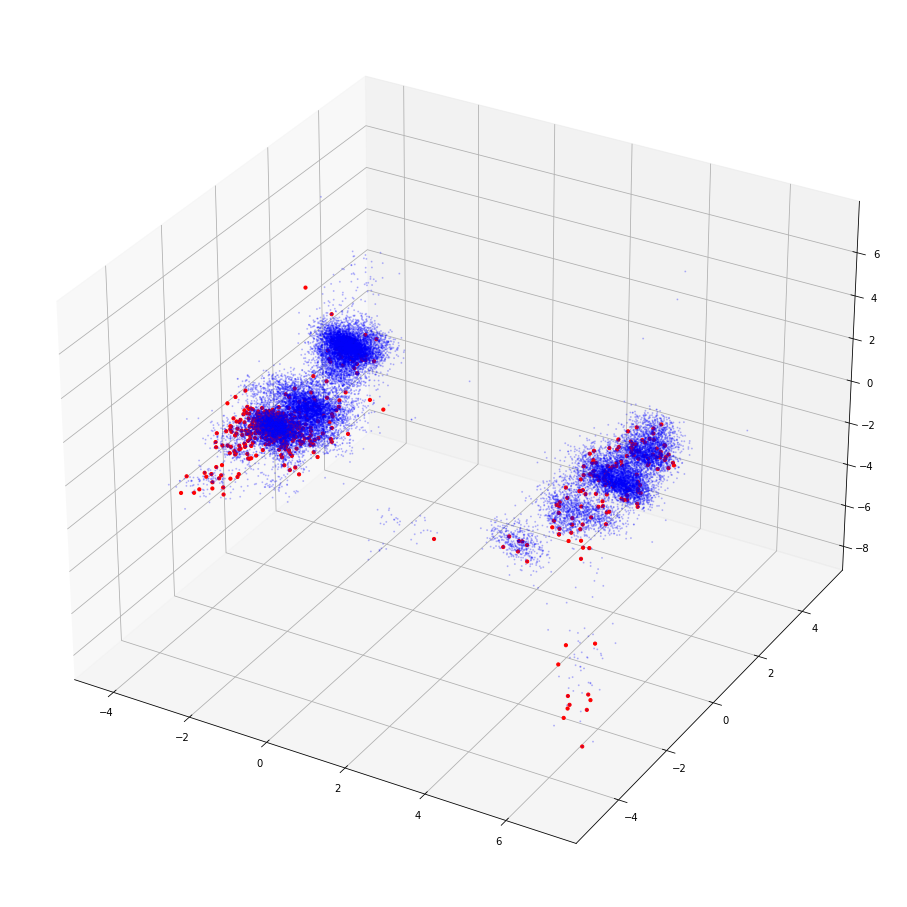

In [15]:
fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
scalar = StandardScaler()
visualization = scalar.fit_transform(xtrain)
visualization = pca.fit_transform(visualization)

# on met a 0 les 2 valeurs extrêmes pour la visualisation (ce sont des échantillons normaux)
visualization[visualization[:,2] > 10] = np.array([[0, 0, 0], [0, 0, 0]])

visualization_1 = visualization[ytrain.loc[ytrain['Anomaly']!=1].index]
visualization_0 = visualization[ytrain.loc[ytrain['Anomaly']!=0].index]
ax.scatter(visualization_1[:, 0], visualization_1[:, 1], visualization_1[:, 2], s=1, c='b', alpha=0.2)
ax.scatter(visualization_0[:, 0], visualization_0[:, 1], visualization_0[:, 2], s=10, c='r', alpha=1);

on voir qu'il n'y a pas de frontière de séparation évidente (sur la représentation PCA) mais il y a certaines régions plus dense en anomalies que d'autres

## Redondance des données

In [16]:
n_dupli_anomaly = len(xtrain.loc[xtrain.duplicated(keep=False)].loc[ytrain['Anomaly']==1])
print(f"pour xtrain :\n-> nombre d'observations liées à un duplicate : {xtrain.duplicated(keep=False).sum()}\n"
     +f"-> nombre d'observations uniques de ces duplicates : {xtrain.duplicated(keep='first').sum()}\n\n"
     +f"parmis eux, il y a {n_dupli_anomaly} anomalies ce qui correspond a "
   +f"{round(n_dupli_anomaly/len(ytrain.loc[ytrain['Anomaly']==1])*100, 3)} % des anomalies présentes dans xtrain")

pour xtrain :
-> nombre d'observations liées à un duplicate : 654
-> nombre d'observations uniques de ces duplicates : 327

parmis eux, il y a 323 anomalies ce qui correspond a 46.609 % des anomalies présentes dans xtrain


cela veut dire qu'il y a 327 échantillons présents en double dans le xtrain et presque la moitié de ces doublons qui représentent presque la moitié des anomalies  
par conséquent cette information est **très importante**, il est donc fortement recommandé de créer une feature ayant pour label 0 ou 1 qui permettra de reconnaitre un échantillon duplicate (1) ou non (0)

In [17]:
# nouveau xtrain, xtest avec la feature informant sur l'appartenance au groupe des duplicates ou non
xtrain_duplicate = xtrain.copy()
xtrain_duplicate['duplicate'] = 0
xtrain_duplicate.loc[xtrain_duplicate.duplicated(keep=False)] = 1

xtest_duplicate = xtest.copy()
xtest_duplicate['duplicate'] = 0
xtest_duplicate.loc[xtest_duplicate.duplicated(keep=False)] = 1

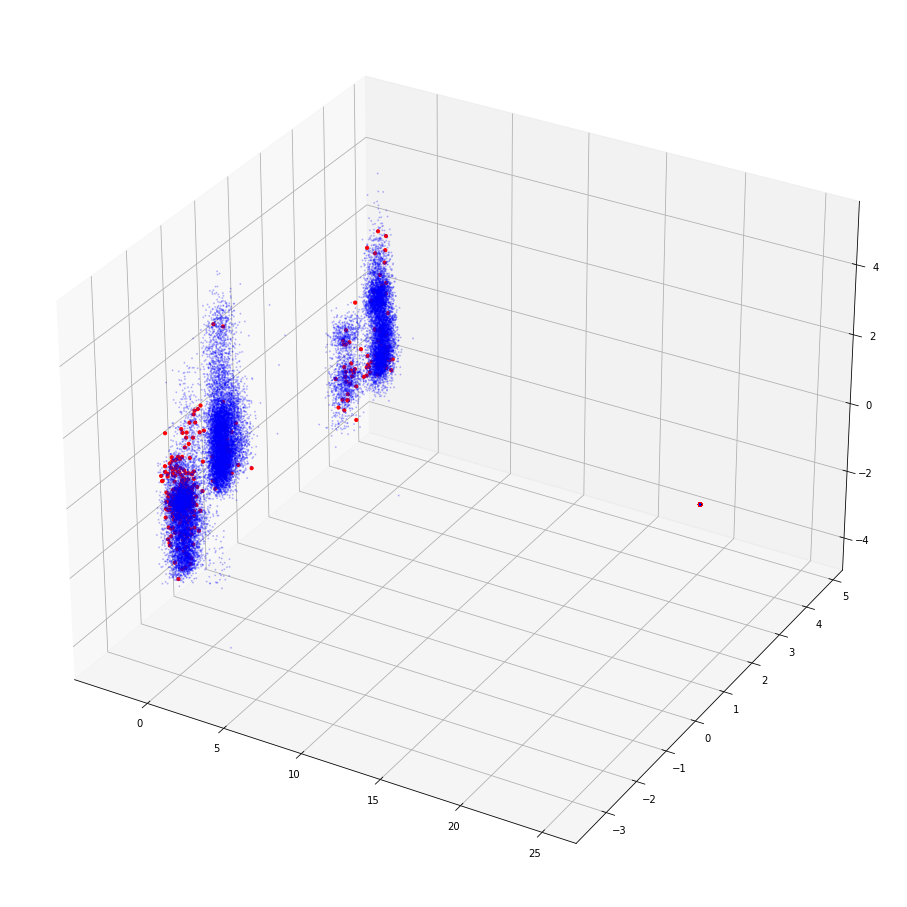

In [18]:
fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)
scalar = StandardScaler()
visualization = scalar.fit_transform(xtrain_duplicate)
visualization = pca.fit_transform(visualization)

visualization_1 = visualization[ytrain.loc[ytrain['Anomaly']!=1].index]
visualization_0 = visualization[ytrain.loc[ytrain['Anomaly']!=0].index]
ax.scatter(visualization_1[:, 0], visualization_1[:, 1], visualization_1[:, 2], s=1, c='b', alpha=0.2)
ax.scatter(visualization_0[:, 0], visualization_0[:, 1], visualization_0[:, 2], s=10, c='r', alpha=1);

On imagine bien maintenant que les échantillons présents dans le cluster très éloigné des autres vont être labélisé comme des anomalies. Cependant il reste la moitié des anomalies qui ne semble pas se dissocier facilement des observations normales

---
# Stratégie  
Nous nous placons ici dans le cas d'un problème de classification supervisé fortement déséquilibré. Dans ce cadre nous maximiserons l'air sous la courbe ROC (AUC).  

Après avoir essayé l'ensemble des algorithmes de classification binaire vu en TP, il semblerait que les méthodes ensemblistes soient celles menant au meilleur score. Nous présenterons ici l'algorithme XGBoost (eXtreme Gradient Boosting) qui est très populaire avec un grand nombre de paramètres à optimiser. Cependant les scores avec un sklearn.ensemble.RandomForestClassifier ou sklearn.ensemble.ExtraTreesClassifier sont très proches.  

Faire une sélection de features (sklearn.feature_selection) ou créer des features / modifier les features (sklearn.preprocessing) ne semble pas améliorer le score final. Nous passerons donc outre ces étapes.  
De même, un oversampling (des anomalies)/ downsampling (des échantillons normaux) n'améliore ici en rien le score tout comme le blending de différentes méthodes ensemblistes.

# XGBoost

In [19]:
# !! 160 fit -> environ 3 minutes !!

xgb = XGBClassifier(eval_metric='auc', objective='binary:logistic', use_label_encoder=False, 
                    scale_pos_weight=0.97488/0.02512) #scale_pos_weight utile pour données déséquilibrées

parameters = {'learning_rate':[0.01, 0.1], 'gamma':[1, 10], 'max_depth':[6, 9], 'subsample':[0.75, 1], 
              'n_estimators': [50, 100]}

clf = GridSearchCV(xgb, parameters, cv=5, scoring='roc_auc', return_train_score=True, verbose=2)
clf.fit(xtrain_duplicate, ytrain.values.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.8s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.6s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.4s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=1, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.4s
[CV] END gamma=1, learn

[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.75; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1; total time=   0.5s
[CV] END gamma=10, learning_rate=0.01, max_depth=6, n_estimators=100, subsample

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, eval_metric='auc',
                                     gamma=None, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=38.80891719745223,
                       

In [20]:
best_index = clf.best_index_
print(f"best test score : {clf.cv_results_['mean_test_score'][best_index]}\n"
     +f"best train score : {clf.cv_results_['mean_train_score'][best_index]}\n"
     +f"best parameters : {clf.best_params_}")

best test score : 0.8870314757862776
best train score : 0.9508729484877065
best parameters : {'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.75}


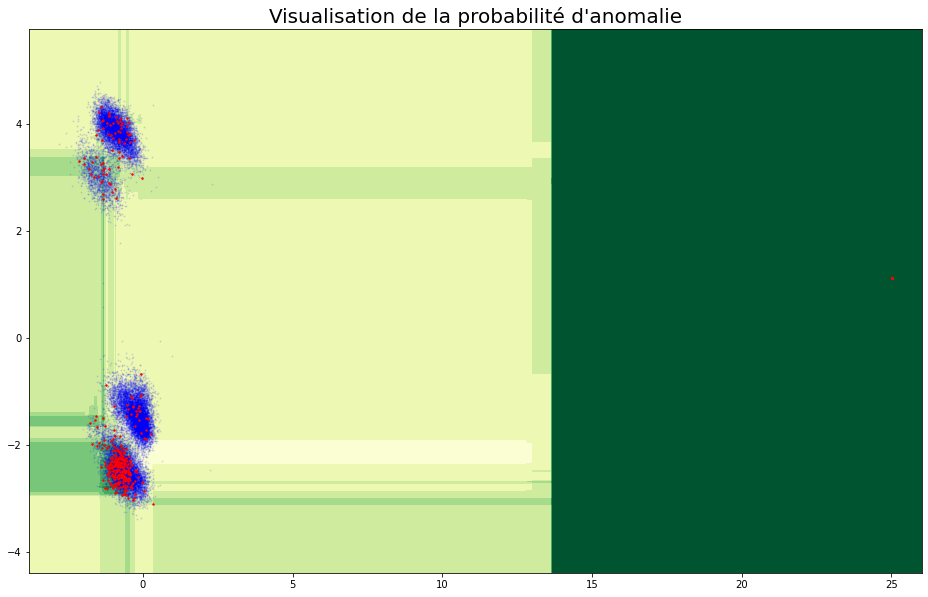

In [21]:
pca = PCA(n_components=2)
scaler = StandardScaler()
x_visu = scaler.fit_transform(xtrain_duplicate)
x_visu = pca.fit_transform(x_visu)

x_min, x_max = x_visu[:, 0].min() - 1, x_visu[:, 0].max() + 1
y_min, y_max = x_visu[:, 1].min() - 1, x_visu[:, 1].max() + 1
h = 0.02 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xgb_best = clf.best_estimator_.fit(x_visu, ytrain.values.ravel())
Z = xgb_best.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, Z, cmap=plt.cm.YlGn, alpha=1)
x_visu_1 = x_visu[ytrain.loc[ytrain['Anomaly']!=1].index]
x_visu_0 = x_visu[ytrain.loc[ytrain['Anomaly']!=0].index]
plt.scatter(x_visu_1[:, 0], x_visu_1[:, 1], s=1, c='b', alpha=0.1)
plt.scatter(x_visu_0[:, 0], x_visu_0[:, 1], s=2, c='r')
plt.title('Visualisation de la probabilité d\'anomalie', fontsize=20);

La figure ci-dessus illustre la probabilité d'avoir une anomalie d'après notre classifieur :  
- vert foncé -> très certainement une anomalie  
- vert clair -> peu de probabilité que ca soit une anomalie  

Avoir mis le poids à environ 39 permet de prendre plus en compte les observations anomaliques. Mettre le poids à 1 m'a permis d'avoir un meilleur score de moins de 1 % mais je l'ai laissé ici pour appuyer l'illustration et parceque avec des anomalies moins mélangées aux échantillons normaux qu'ici ça devrait aider fortement.

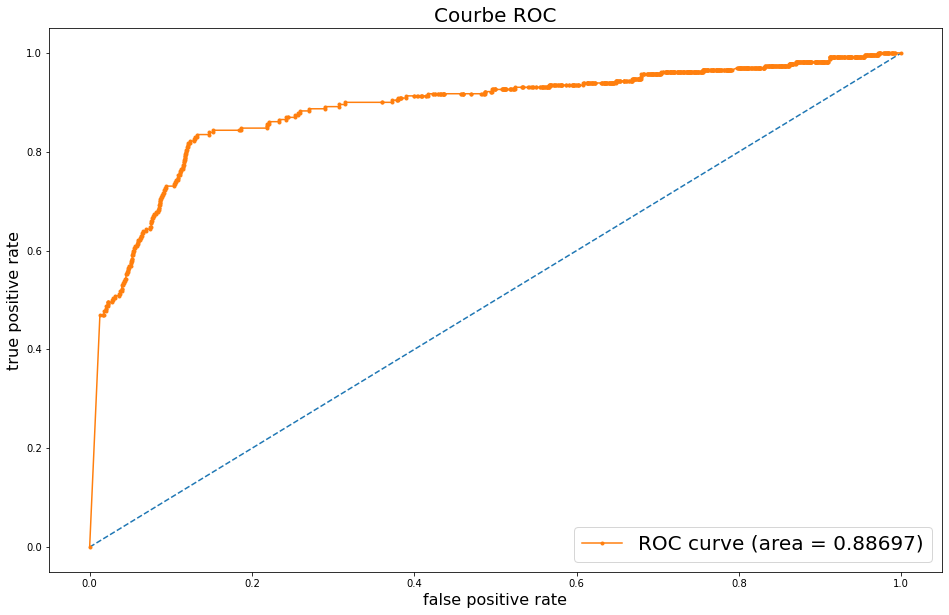

In [22]:
xtrain_visu, xval_visu, ytrain_visu, yval_visu = train_test_split(xtrain_duplicate, ytrain, test_size=0.33, 
                                                                  random_state=42, shuffle=True)
xgb_best = clf.best_estimator_.fit(xtrain_visu, ytrain_visu)

plt.figure(figsize=(16, 10))

# Courbe ROC
ypred_proba = xgb_best.predict_proba(xval_visu)[:,1]
fpr, tpr, _ = roc_curve(yval_visu, ypred_proba)
b_fpr, b_tpr, _ = roc_curve(yval_visu, [0 for _ in range(len(yval_visu))])
plt.plot(b_fpr, b_tpr, linestyle='--')
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (area = {round(roc_auc_score(yval_visu, ypred_proba), 5)})')
plt.xlabel('false positive rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)
plt.legend(loc="lower right", fontsize=20)
plt.title('Courbe ROC', fontsize=20)
plt.show()

La figure ci-dessus illustre la courbe ROC qui nous permet de calculer l'AUC utilisée pour nous classer lors de ce data challenge

# Conclusion

Pour améliorer le score il faudrait pouvoir trouver une transformation qui permette de faire ressortir les anomalies des échantillons normaux comme on peut le voir sur l'illustration avec le PCA.  

Sans utiliser la stratégie du duplicate, je n'ai pas réussi à monter plus haut que 80% sauf en utilisant XGBOD qui est très bien pensé : on créer des features grace aux decision_function d'algorithmes non supervisé de clustering / détection d'outliers ce qui apporte de l'information et ensuite on applique un XGBoost sur le nouveau jeu de données. Cela m'a permis de dépasser les 80%.  
Cependant, avec la stratégie du duplicate j'obtiens un meilleur score avec une méthode moins complexe donc je n'ai pas présenté XGBOD ici (c'est également très long à optimiser..). https://pyod.readthedocs.io/en/latest/_modules/pyod/models/xgbod.html#XGBOD